In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as repr
import researchpy as rp
from scipy.stats import levene
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
import os

In [2]:
df = pd.read_pickle('datos/bikes_limpio.pkl') 

In [3]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes
indice,,,,,,,,,,,,,,,
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,2018-05-01,primavera,2018,May,0,Martes,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# IDENTIFICAR OUTLIERS

In [4]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
    
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices

In [5]:
numericas = df.select_dtypes(include = np.number)

In [6]:
lista_col = list(numericas.columns)

In [7]:
diccionario_outliers = detectar_outliers(lista_col, df)

In [8]:
# iteramos por el diccionarios y cambiamos los outliers por nulos, para posteriormente poder tratarlos
 
for k, v in diccionario_outliers.items():
    for i in v:
        df.loc[i,k] = np.nan # usando el loc, reemmplazamos los valores de los outliers por los nulos 

In [9]:
imputer = IterativeImputer(n_nearest_features = None, 
                           imputation_order = 'ascending')

In [10]:
imputer.fit(numericas)

IterativeImputer()

In [11]:
imputer_trans = imputer.transform (numericas)

In [12]:
df_numericas_trans = pd.DataFrame(imputer_trans, columns = numericas.columns)

In [13]:
#Comprobamos que la transformación ha funcionado

df_numericas_trans.isnull().sum()

temperatura           0
sensacion_term        0
humedad               0
velocidad_viento      0
cliente_casual        0
cliente_registrado    0
total_clientes        0
dtype: int64

In [14]:
#Eliminamos las columnas en el df original (ya tratadas en el df_numéricas) para posteriormente realizar la concatenación

df.drop(df_numericas_trans.columns, axis = 1, inplace=True)

In [15]:
#Concatenamos el df transformado

df_final = pd.concat([df, df_numericas_trans], axis = 1, join = 'inner')

In [16]:
df_final.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,17.68695,69.6087,16.652113,131.0,670.0,801.0
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,9.47025,43.7273,16.636703,120.0,1229.0,1349.0
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.60610,59.0435,10.739832,108.0,1454.0,1562.0
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,11.46350,43.6957,12.522300,82.0,1518.0,1600.0
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,11.66045,51.8261,6.000868,88.0,1518.0,1606.0


In [17]:
#Comprobamos que la fusión de ambos df ya tratados y limpios no ha generado nulos

df_final.isnull().sum()

fecha                 0
estacion              0
año                   0
mes                   0
festivo               0
dia_semana            0
dia_laboral           0
tiempo                0
temperatura           0
sensacion_term        0
humedad               0
velocidad_viento      0
cliente_casual        0
cliente_registrado    0
total_clientes        0
dtype: int64

## GUARDAR EL DATAFRAME LIMPIO EN DIFERENTES ARCHIVOS

In [18]:
df_final.to_csv('datos/bikes_limpio_final.csv')

In [19]:
df_final.to_pickle('datos/bikes_limpio_final.pkl')

## ASUNCIONES

In [20]:
df = pd.read_pickle('datos/bikes_limpio_final.pkl')

In [21]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,17.68695,69.6087,16.652113,131.0,670.0,801.0
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,9.47025,43.7273,16.636703,120.0,1229.0,1349.0
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.60610,59.0435,10.739832,108.0,1454.0,1562.0
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,11.46350,43.6957,12.522300,82.0,1518.0,1600.0
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,11.66045,51.8261,6.000868,88.0,1518.0,1606.0


### Evaluamos la normalidad de nuestras VR

- Las gráficas realizadas en el proceso de EDA nos han permitido ver que los datos de nuestras VR no parecían muy normales. No obstante, realizamos shapiro para confirmar.

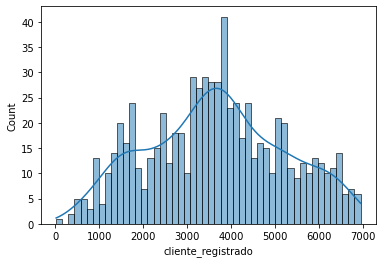

In [22]:
sns.histplot(x='cliente_registrado', data=df, kde=True, bins=50);

In [23]:
stats.shapiro(df['cliente_registrado'])

ShapiroResult(statistic=0.984423041343689, pvalue=5.26375856679806e-07)

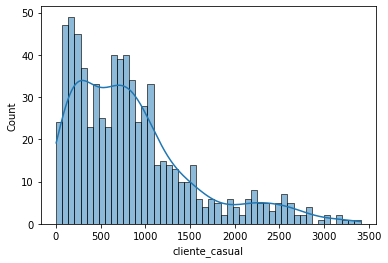

In [24]:
sns.histplot(x='cliente_casual', data=df, kde=True, bins=50);

In [25]:
stats.shapiro(df['cliente_casual'])

ShapiroResult(statistic=0.8853672742843628, pvalue=8.40218526941286e-23)

#### OBSERVACIONES:

- Nuestros datos no son normales:
  - los datos de los clientes_casuales están sesgados a la derecha y la distribución está muy lejos de ser normal.
  - los datos de los clientes_registrados parecen más "normales" pero observando el valor del p-value observamos que es menor que 0.05 y por tanto los datos no son normales tampoco.

 ### NORMALIZACIÓN DE VR

In [26]:
df.columns

Index(['fecha', 'estacion', 'año', 'mes', 'festivo', 'dia_semana',
       'dia_laboral', 'tiempo', 'temperatura', 'sensacion_term', 'humedad',
       'velocidad_viento', 'cliente_casual', 'cliente_registrado',
       'total_clientes'],
      dtype='object')

In [27]:
df['cliente_casual_box'], lambda_ajustada = stats.boxcox(df['cliente_casual'])

In [28]:
df['cliente_registrado_box'], lambda_ajustada = stats.boxcox(df['cliente_registrado'])

In [29]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes,cliente_casual_box,cliente_registrado_box
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,17.68695,69.6087,16.652113,131.0,670.0,801.0,11.502570,271.249335
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,9.47025,43.7273,16.636703,120.0,1229.0,1349.0,11.104509,450.623255
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.60610,59.0435,10.739832,108.0,1454.0,1562.0,10.640549,518.610737
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,11.46350,43.6957,12.522300,82.0,1518.0,1600.0,9.497633,537.619305
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,11.66045,51.8261,6.000868,88.0,1518.0,1606.0,9.781356,537.619305


/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


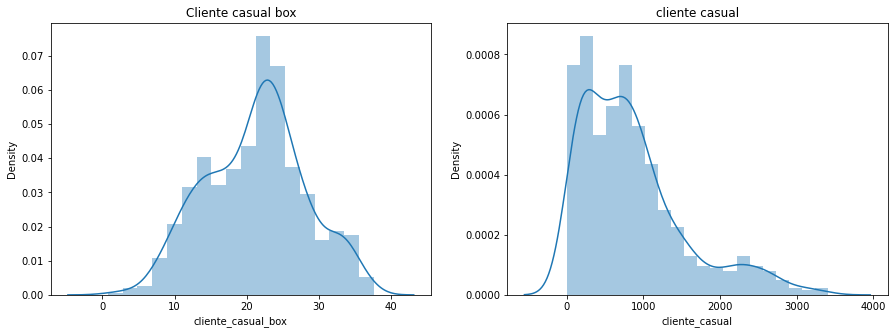

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('Cliente casual box')
axes[1].set_title('cliente casual')

sns.distplot(df['cliente_casual_box'] ,ax = axes[0])
sns.distplot(df['cliente_casual'], ax = axes[1]);

In [31]:
stats.shapiro(df["cliente_casual_box"])

ShapiroResult(statistic=0.9915054440498352, pvalue=0.00033743452513590455)

/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


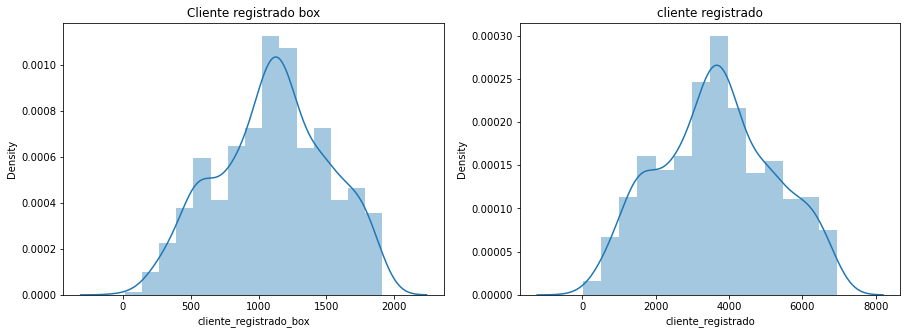

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('Cliente registrado box')
axes[1].set_title('cliente registrado')

sns.distplot(df['cliente_registrado_box'] ,ax = axes[0])
sns.distplot(df['cliente_registrado'], ax = axes[1]);

In [33]:
stats.shapiro(df["cliente_registrado_box"])

ShapiroResult(statistic=0.9855146408081055, pvalue=1.2759210221702233e-06)

#### OBSERVACIONES:

- Al aplicar el método boxcox, hemos comproado que nuestros datos no se pueden normalizar dado que nuestro p-value es menor a 0,5.

### COMPROBAMOS LA INDEPENDENCIA

In [34]:
categoricas = df.select_dtypes(exclude=np.number)
categoricas.columns

Index(['fecha', 'estacion', 'año', 'mes', 'festivo', 'dia_semana',
       'dia_laboral', 'tiempo'],
      dtype='object')

In [35]:
crosstab, test_results, expected = rp.crosstab(df["INDUS"], df["CHAS"],
                                   test= "chi-square",
                                   expected_freqs= True,
                                   prop= "cell")

KeyError: 'INDUS'

In [ ]:
for i, col in enumerate(categoricas.columns):
    
    while i+1 <= len(categoricas.columns):
        col1 = categoricas.columns[i]
        col2 = categoricas.columns[i+1]

        crosstab, test_results, expected = rp.crosstab(df[col1], df[col2],
                                test= "chi-square",
                                expected_freqs= True,
                                prop= "cell")
        print(col1, col2)
        
        display(test_results)